In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import style  
import seaborn as sns
import sklearn as sk
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from operator import itemgetter
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.model_selection import train_test_split
import re
import warnings
warnings.filterwarnings("ignore")
style.use('seaborn')      
plt.rcParams['font.sans-serif'] = ['SimHei']   
plt.rcParams['axes.unicode_minus'] = False  

In [2]:
train = pd.read_csv("titanic_train_scaled.csv")
test = pd.read_csv("titanic_test_scaled.csv")

In [3]:
del train['Unnamed: 0']

In [4]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeC,FamilySize,Alone,NameLength,FareC,NoCabin,Position,Pair
0,0,3,0,-0.559472,1,0,-0.502445,0,0,1.0,1,0,-0.427451,0.0,True,0,2
1,1,1,1,0.609661,1,0,0.786845,1,2,2.0,1,0,2.590962,3.0,False,3,1
2,1,3,1,-0.267189,0,0,-0.488854,0,1,1.0,0,1,-0.535252,1.0,True,0,2
3,1,1,1,0.390449,1,0,0.420730,0,2,2.0,1,0,1.836359,3.0,False,3,1
4,0,3,0,0.390449,0,0,-0.486337,0,0,2.0,0,1,-0.319651,1.0,True,0,2


In [5]:
xx = train.copy()
del xx['Survived']
predictors =[str(x) for x in xx.keys()]

(891, 6)
Under f_classif selection, the best 6 features is:Index(['Pclass', 'Sex', 'Title', 'NameLength', 'FareC', 'NoCabin'], dtype='object')


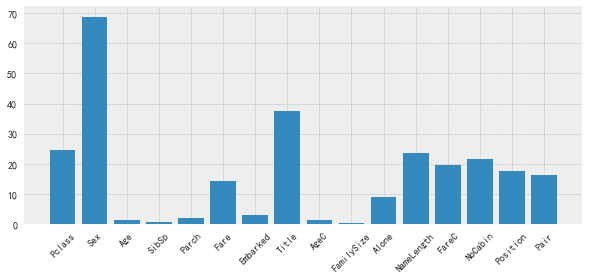

In [6]:
# Perform feature selection: f_classif
X, y = (train[predictors], train["Survived"])
selector = SelectKBest(f_classif, k=6)
selector.fit(X,y)

X_new = selector.transform(X)
print(X_new.shape)

print("Under f_classif selection, the best {} features is:{}".format(len(selector.get_support(indices=True)),X.columns[selector.get_support(indices=True)]))

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

plt.figure(figsize=(10, 4))
plt.style.use('bmh')
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation=45)
plt.show()

In [11]:
import itertools

ls = itertools.combinations(predictors, 2)
c=[]

for l in ls:
    c.append([l[0],l[1]])

for l in c:
    con1=train[l[0]]+train[l[1]]
    con2=train[l[0]]-train[l[1]]
    con3=train[l[0]]*train[l[1]]
    train = pd.concat([train, con1,con2,con3], axis=1)
train.head()

In [22]:
# Trial Comparison of different combinations of the parameters
from tqdm import tqdm
score = []
X=train.copy()
del X['Survived']
y=train['Survived']

for i in tqdm(range(2,100)):
    for j in range(2,100):
        for e in range(20,1000):
            alg = RandomForestClassifier(random_state=1, n_estimators=e, min_samples_split=i, min_samples_leaf=j)
            # Compute the accuracy score for all the cross validation folds.  (much simpler than what we did before!)
            scores = cross_val_score(alg, X, y, cv=10)
            # Take the mean of the scores (because we have one for each fold)
            score.append([[e,i,j],scores.mean()])


100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [45:32<00:00, 329.79s/it]


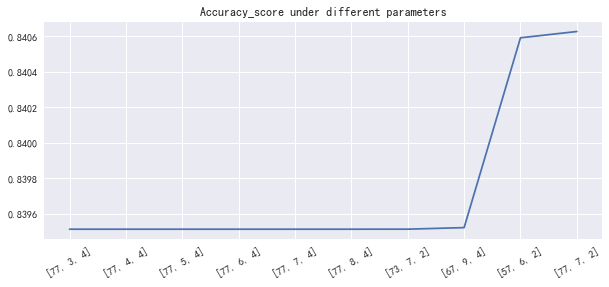

In [23]:
# Sort the selection of parameters according to Accuracy score
score.sort(key = itemgetter(1),reverse=0)
score_top10 = score[-10:]
sc=np.array(score_top10)[:,-1]
para=np.array(score_top10)[:,0]
para = [str(x) for x in para]

# 2 ways of visulization plot
plt.figure(figsize=(10, 4))  
plt.xticks(rotation=30) 
plt.plot(para,sc)
plt.title('Accuracy_score under different parameters') 
plt.show()


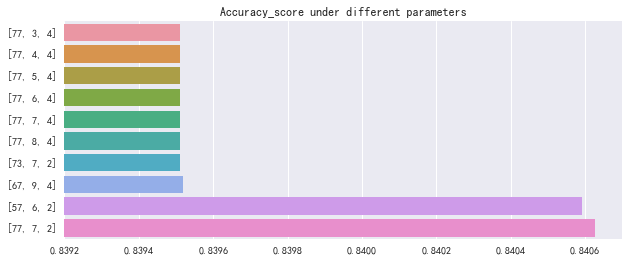

The highest score is 0.8406276224400522.


In [28]:
plt.figure(figsize=(10, 4))  
sns.barplot(sc,para)
plt.xlim([0.8392,0.8407])  
plt.title('Accuracy_score under different parameters') 
plt.show()

print('The highest score is {}.'.format(np.max(sc)))

roc_auc= 0.8064285714285715


Text(0.5, 1.0, 'Receiver Operating Characteristic Curve')

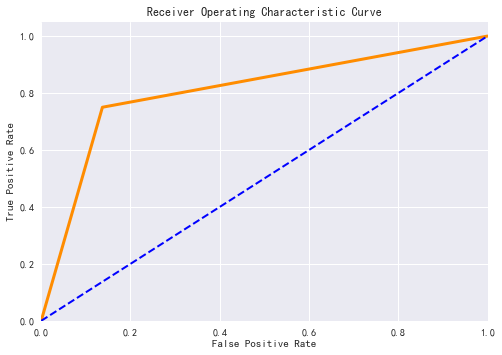

In [29]:
X=train.copy()
del X['Survived']
y=train['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
alg = RandomForestClassifier(random_state=1, n_estimators=52, min_samples_split=7, min_samples_leaf=2)
alg.fit(X_train,y_train)
# Compute the accuracy score for all the cross validation folds.  (much simpler than what we did before!)

y_scores = alg.predict(X_test)

fpr, tpr, _ = sk.metrics.roc_curve(y_test, y_scores)
roc_auc=auc(fpr,tpr)
print('roc_auc=',roc_auc)
plt.plot(fpr,tpr,color='darkorange',lw=3,label='ROC_Curve')
plt.plot([0,1],[0,1],color='blue',lw=2,linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')